In [1]:
import sys
import os
import random
import gc
import re
import time
import torch
import numpy as np
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from scipy.sparse import csr_matrix
import itertools
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
# import nltk
# nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

DATA_CSV = Path("../data/sampled_hotpot.csv")
UTILITY_CACHE_BASE_DIR_ROOT = Path("../Experiment_data") / DATA_CSV.stem

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Fixed color palette per method family/name
METHOD_COLORS = {
    "FM-S": "#f7b882",
    "FM-B": "#DD6B07",
    "Spex-S": "#f87878",
    "Spex-B": "#D10505",
    "Shapiq-S": "#7af77a",
    "Shapiq-B": "#018d01",
    "ProxySpex-S": "#bf83f7",
    "ProxySpex-B": "#760adb",
    "Exac-Shapley": "#f2f27a",
    "Exac-Banzhaf": "#B4B404",
    "Exac-FBII": "#440344",
    "Exac-FSII": "#04B49D",
    "FM-P": "#7d51f8",
    "Facile": "#0d0aaf",
    
    "ContextCite": "#0d69ac",
}

def family_of(method_key: str) -> str:
    """Map a notebook method key to a color family key."""
    if method_key.startswith("FM-S"):
        return "FM-S"
    elif method_key.startswith("FM-B"):
        return "FM-B"
    elif method_key.startswith("Spex-S"):
        return "Spex-S"
    elif method_key.startswith("Spex-B"):
        return "Spex-B"
    elif method_key.startswith("Shapiq-S"):
        return "Shapiq-S"
    elif method_key.startswith("Shapiq-B"):
        return "Shapiq-B"
    elif method_key.startswith("ContextCite"):
        return "ContextCite"
    elif method_key.startswith("ProxySpex-S"):
        return "ProxySpex-S"
    elif method_key.startswith("ProxySpex-B"):
        return "ProxySpex-B"
    elif method_key.startswith("Exact-FSII"):
        return "Exac-FSII"
    elif method_key.startswith("Exact-FBII"):
        return "Exac-FBII"
    elif method_key.startswith("Exact-Shap"):
        return "Exac-Shap"
    elif method_key.startswith("Exact-Banzhaf"):
        return "Exac-Banzhaf"
    elif method_key.startswith("FM-P"):
        return "FM-P"
    elif method_key.startswith("Facile"):
        return "Facile"
    elif method_key in ("FM_1", "FM_2", "FM_3", "FM_4", "FM_5"):
        return method_key

def get_color(method_key: str) -> str:
    return METHOD_COLORS.get(family_of(method_key))


# A colormap to pick new unique colors from
# cmap = plt.cm.tab20
# unknown_colors = {}
# unknown_index = 0
# def get_color(method):
#     global unknown_index
#     if method in METHOD_COLORS:
#         return METHOD_COLORS[method]
    
#     if method not in unknown_colors:
#         unknown_colors[method] = cmap(unknown_index % cmap.N)
#         unknown_index += 1
#     return unknown_colors[method]


# Set matplotlib default cycle to the custom palette (keeps plotting consistent)
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=list(METHOD_COLORS.values()))
plt.rcParams.update({'font.size': 24})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [4]:
dfin=pd.read_csv("../data/sampled_hotpot.csv")
dfin.reordered_sentences=dfin.reordered_sentences.apply(ast.literal_eval)
# dfin["paragraphs"] = dfin["paragraphs"].apply(lambda p: p[:5]+ [p[1]] + p[5:])

In [5]:
def GT(i):
    if dfin["len_gt"][i]==2:
        return [0,1]
    elif dfin["len_gt"][i]==3:
        return [0,1,2]
    elif dfin["len_gt"][i]==4:
        return [0,1,2,3]

In [6]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()
utility_cache_base_dir = f"../Experiment_data/sampled_hotpot/{model_path.split('/')[1]}"

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [7]:
num_questions_to_run = len(dfin)
K_VALUES = [1, 2, 3, 4, 5]
all_results = []
extras = []

for i in range(num_questions_to_run):
    query = dfin.question[i]
    # if res[i]=="True":
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs = dfin.reordered_sentences[i][:10]
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path,
        utility_mode='log-perplexity'
    )
    
    full_budget=pow(2,harness.n_items)
    # res = evaluate(df.question[i], harness.target_response, df.answer[i])
    # print(res)
    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map ={"XS":32,"S":64, "M":128, "L":264, "XL":528, "XXL":728}

        # Store FM models for later R²/MSE
        fm_models = {}
        best_by_metric={}
        methods_results['Exact-Shap']=harness._calculate_exact(method='SV')
        # methods_results['Exact-Banzhaf']=harness._calculate_exact(method='BV')
        for size_key, actual_samples in m_samples_map.items():
            print(f"Running sample size: {actual_samples}")
            methods_results[f"ContextCite_{actual_samples}"], fm_models[f"ContextCite_{actual_samples}"] = harness.compute_contextcite(
                num_samples=actual_samples, seed=SEED
            )

            # Facile (loop over ranks)
            # sampled_tuples = harness._generate_sampled_ablations(num_samples=actual_samples, sampling_method="bf", seed=SEED)
            # utilities_for_samples = [harness.get_utility(tuple(v_tuple), mode=harness.utility_mode) for v_tuple in sampled_tuples]
            
            # # Prepare data
            # X = np.array(sampled_tuples, dtype=np.float32)
            # y = np.array(utilities_for_samples, dtype=np.float32)  
            # all_pairs = pairs_hamming_1_bitmask(np.asarray(X).astype(np.uint8))
            # # for rank in [1,2,4,8]:
            # methods_results[f"Facile_dbf_{actual_samples}"], extra_results[f"Facile_dbf_{actual_samples}"], fm_models[f"Facile_dbf_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="util_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_ubf_{actual_samples}"], extra_results[f"Facile_ubf_{actual_samples}"], fm_models[f"Facile_ubf_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="util_mse",
            #     rank=4
            # )

            # sampled_tuples = harness._generate_sampled_ablations(num_samples=actual_samples, sampling_method="bf_kernelshap", seed=SEED)
            # utilities_for_samples = [harness.get_utility(tuple(v_tuple), mode=harness.utility_mode) for v_tuple in sampled_tuples]
            
            # # Prepare data
            # X = np.array(sampled_tuples, dtype=np.float32)
            # y = np.array(utilities_for_samples, dtype=np.float32)  
            # all_pairs = pairs_hamming_1_bitmask(np.asarray(X).astype(np.uint8))
            # # for rank in [1,2,4,8]:
            # methods_results[f"Facile_dbfk_{actual_samples}"], extra_results[f"Facile_dbfk_{actual_samples}"], fm_models[f"Facile_dbfk_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss_type="delta_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_ubfk_{actual_samples}"], extra_results[f"Facile_ubfk_{actual_samples}"], fm_models[f"Facile_ubfk_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss_type="util_mse",
            #     rank=4
            # )

            # sampled_tuples = harness._generate_sampled_ablations(num_samples=actual_samples, sampling_method="bf_uniform", seed=SEED)
            # utilities_for_samples = [harness.get_utility(tuple(v_tuple), mode=harness.utility_mode) for v_tuple in sampled_tuples]
            
            # # Prepare data
            # X = np.array(sampled_tuples, dtype=np.float32)
            # y = np.array(utilities_for_samples, dtype=np.float32)  
            # all_pairs = pairs_hamming_1_bitmask(np.asarray(X).astype(np.uint8))
            # # for rank in [1,2,4,8]:
            # methods_results[f"Facile_dbfu_{actual_samples}"], extra_results[f"Facile_dbfu_{actual_samples}"], fm_models[f"Facile_dbfu_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="delta_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_ubfu_{actual_samples}"], extra_results[f"Facile_ubfu_{actual_samples}"], fm_models[f"Facile_ubfu_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="util_mse",
            #     rank=4
            # )

            # sampled_tuples = harness._generate_sampled_ablations(num_samples=actual_samples, sampling_method="kernelshap", seed=SEED)
            # utilities_for_samples = [harness.get_utility(tuple(v_tuple), mode=harness.utility_mode) for v_tuple in sampled_tuples]
            
            # # Prepare data
            # X = np.array(sampled_tuples, dtype=np.float32)
            # y = np.array(utilities_for_samples, dtype=np.float32)  
            # all_pairs = pairs_hamming_1_bitmask(np.asarray(X).astype(np.uint8))
            # # for rank in [1,2,4,8]:
            # methods_results[f"Facile_dk_{actual_samples}"], extra_results[f"Facile_dk_{actual_samples}"], fm_models[f"Facile_dk_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="delta_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_uk_{actual_samples}"], extra_results[f"Facile_uk_{actual_samples}"], fm_models[f"Facile_uk_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="util_mse",
            #     rank=4
            # )

            # sampled_tuples = harness._generate_sampled_ablations(num_samples=actual_samples, sampling_method="uniform", seed=SEED)
            # utilities_for_samples = [harness.get_utility(tuple(v_tuple), mode=harness.utility_mode) for v_tuple in sampled_tuples]
            
            # # Prepare data
            # X = np.array(sampled_tuples, dtype=np.float32)
            # y = np.array(utilities_for_samples, dtype=np.float32)  
            # all_pairs = pairs_hamming_1_bitmask(np.asarray(X).astype(np.uint8))
            # # for rank in [1,2,4,8]:
            # methods_results[f"Facile_du_{actual_samples}"], extra_results[f"Facile__du_{actual_samples}"], fm_models[f"Facile_du_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="delta_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_uu_{actual_samples}"], extra_results[f"Facile_uu_{actual_samples}"], fm_models[f"Facile_uu_{actual_samples}"] = harness.compute_facile(
            #     X=X,
            #     y=y,
            #     all_pairs=all_pairs,
            #     loss="util_mse",
            #     rank=4
            # )
            # methods_results[f"Facile_{actual_samples}"], extra_results[f"Facile_{actual_samples}"], fm_models[f"Facile_{actual_samples}"] = harness.compute_facilehp(
            #     num_samples=actual_samples, seed=SEED)
    
            # methods_results[f"Facile_{rank}_{actual_samples}"], extra_results[f"Facile_{rank}_{actual_samples}"], fm_models[f"Facile_{rank}_{actual_samples}"] = harness.compute_facile(
            #         num_samples=actual_samples,
            #         seed=SEED,
            #         rank=rank)
            methods_results[f"FACILE_{actual_samples}"], extra_results[f"FACILE_{actual_samples}"], fm_models[f"FACILE_{actual_samples}"] = harness.compute_wss(
                    num_samples=actual_samples,
                    seed=SEED,
                    sampling_method="bf_kernelshap",
                    sur_type="fm_tuning",
                    selection_metric="r2_delta")
            # methods_results[f"FN-S_{actual_samples}"], extra_results[f"FN-S_{actual_samples}"], fm_models[f"FN-S_{actual_samples}"] = harness.compute_facile(
            #         num_samples=actual_samples,
            #         seed=SEED)
            # for selection_metric in ["mse_util", "mse_delta", "r2_util", "r2_delta"]:
            #     methods_results[f"FM_{selection_metric}_{actual_samples}"], extra_results[f"FM_{selection_metric}_{actual_samples}"], fm_models[f"FM_{selection_metric}_{actual_samples}"] = harness.compute_wss(
            #             num_samples=actual_samples,
            #             seed=SEED,
            #             sampling="kernelshap",
            #             sur_type="fm_tuning",
            #             selection_metric=selection_metric)
                # best_by_metric[f'{selection_metric}_{actual_samples}'].append(best)
            # methods_results[f"FR_{actual_samples}"], extra_results[f"FR_{actual_samples}"], fm_models[f"FR_{actual_samples}"] = harness.compute_wss(
            #     num_samples=actual_samples,
            #     seed=SEED,
            #     sampling="uniform",
            #     sur_type="fm",
            #     rank=0
            #         )
                    
            # FM models with dynamic k pruning
            # methods_results[f"FM_k_dynamic_{actual_samples}"], extra_results[f"FM_k_dynamic_{actual_samples}"], fm_models[f"FM_k_dynamic_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(
            #     num_samples=actual_samples,
            #     pruning_strategy="top_k",
            #     initial_rank=0,
            #     final_rank=5,
            # )
            # attributionshapiq, interactionshapiq, fm_models[f"Shapiq_{actual_samples}"] = harness.compute_shapiq(budget=actual_samples, method='FSII')
            # methods_results[f"Shapiq_{actual_samples}"] = attributionshapiq
            # extra_results.update({
            #     f"Shapiq_{actual_samples}":interactionshapiq
            #                                                             })
            # try:
            #     attributionshap, interactionshap, fm_models[f"Spex_{actual_samples}"] = harness.compute_spex(sample_budget=actual_samples, max_order=harness.n_items, method='FSII')
            #     methods_results[f"Spex_{actual_samples}"] = attributionshap

            #     extra_results.update({
            #     f"Spex_{actual_samples}":interactionshap
            #                                                             })
            # except Exception: 
            #     pass

            # try:
            #     attributionban, interactionban, fm_models[f"ProxySpex_{actual_samples}"] = harness.compute_proxyspex(sample_budget=actual_samples, max_order=harness.n_items, method='FSII')
            #     methods_results[f"ProxySpex_{actual_samples}"] = attributionban
            #     extra_results.update({
            #         f"ProxySpex_{actual_samples}":interactionban
            #                                                             })

            # except Exception: 
            #     pass

        attributionxs, interactionxs, fm_models["Exact-FSII"] = harness.compute_exact_faith(max_order=2, method='FSII')

        extra_results.update({
        "Exact-FSII": interactionxs
    })
        methods_results["Exact-FSII"]=attributionxs

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, fm_models, K_VALUES
        )

        # R² and Delta R²
        metrics_results["R2"] = harness.r2(methods_results,50, models=fm_models)
        metrics_results["Delta_R2"] = harness.delta_r2(methods_results,20, models=fm_models)
        metrics_results['Recall']=harness.recall_at_k(GT(i), methods_results, K_VALUES)

        # LDS per method
        metrics_results["LDS"] = harness.lds(methods_results,50, models=fm_models)
        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": dfin.answer[i],
            "response": harness.target_response,
            "methods": methods_results,
            "metrics": metrics_results
        })
        extras.append(extra_results)

        # Save utility cache
        harness.save_utility_cache(current_utility_path)


--- Question 1/99: Which magazine was started first Arthur's Magazine or First ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx0.pkl...
Successfully loaded 1024 cached utility entries.


2026-02-04 23:37:45.030727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-04 23:37:45.077506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 23:37:46.386095: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Running sample size: 32
  Best rank by   r2_delta: rank=1
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=2
Running sample size: 264
  Best rank by   r2_delta: rank=2
Running sample size: 528
  Best rank by   r2_delta: rank=2
Running sample size: 728
  Best rank by   r2_delta: rank=8
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx0.pkl...
Save complete.

--- Question 2/99: The Oberoi family is part of a hotel company that has a head... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx1.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=8
Running sample size: 128
  Best rank by   r2_delta: rank=8
Running sample size: 264
  Best rank by   r2_delta: rank=8
Running s

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx10.pkl...
Save complete.

--- Question 12/99: Which state does the drug stores, of which the CEO is Warren... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx11.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=4
Running sample size: 128
  Best rank by   r2_delta: rank=1
Running sample size: 264
  Best rank by   r2_delta: rank=8
Running sample size: 528
  Best rank by   r2_delta: rank=4
Running sample size: 728
  Best rank by   r2_delta: rank=4
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx11.pkl...
Save complete.

--- Question 13/99: Which  American politician did Donahue replaced ... ---
Main Process: Attempting

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the

Running sample size: 32
  Best rank by   r2_delta: rank=2
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=1
Running sample size: 264
  Best rank by   r2_delta: rank=4
Running sample size: 528
  Best rank by   r2_delta: rank=1
Running sample size: 728
  Best rank by   r2_delta: rank=4
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx17.pkl...
Save complete.

--- Question 19/99: 750 7th Avenue and 101 Park Avenue, are located in which cit... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx18.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=4
Running sample size: 264
  Best rank by   r2_delta: rank=1
Runnin

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx25.pkl...
Save complete.

--- Question 27/99: Guitars for Wounded Warriors is an album that was recorded i... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx26.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=1
Running sample size: 264
  Best rank by   r2_delta: rank=8
Running sample size: 528
  Best rank by   r2_delta: rank=4
Running sample size: 728
  Best rank by   r2_delta: rank=8
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx26.pkl...
Save complete.

--- Question 28/99: Who was born first, Francis Nethersole or Elizabeth Stuart?... ---
Main Process:

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the

Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=8
Running sample size: 264
  Best rank by   r2_delta: rank=2
Running sample size: 528
  Best rank by   r2_delta: rank=4
Running sample size: 728
  Best rank by   r2_delta: rank=8
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx31.pkl...
Save complete.

--- Question 33/99: The Southern Railway runs from Vienna to Graz and the border... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx32.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=2
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=1
Running sample size: 264
  Best rank by   r2_delta: rank=2
Runnin

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the

Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx37.pkl...
Save complete.

--- Question 39/99: Who is the director of the 2003 film which has scenes in it ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx38.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=4
Running sample size: 64
  Best rank by   r2_delta: rank=2
Running sample size: 128
  Best rank by   r2_delta: rank=1
Running sample size: 264
  Best rank by   r2_delta: rank=2
Running sample size: 528
  Best rank by   r2_delta: rank=4
Running sample size: 728
  Best rank by   r2_delta: rank=8
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx38.pkl...
Save complete.

--- Question 40/99: Which documentary is about Finnish rock groups, Adam Clayton... ---
Main Process

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx39.pkl...
Save complete.

--- Question 41/99: The axial turbojet Pirna 014 was designed by engineers from ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx40.pkl...
Successfully loaded 1024 cached utility entries.
Running sample size: 32
  Best rank by   r2_delta: rank=2
Running sample size: 64
  Best rank by   r2_delta: rank=4
Running sample size: 128
  Best rank by   r2_delta: rank=2
Running sample size: 264
  Best rank by   r2_delta: rank=8
Running sample size: 528
  Best rank by   r2_delta: rank=4
Running sample size: 728
  Best rank by   r2_delta: rank=4
Main Process: Saving 1024 utility entries to ../Experiment_data/sampled_hotpot/Qwen2.5-3B-Instruct/utilities_q_idx40.pkl...
Save complete.

--- Question 42/99: What American country music singer-songwriter, born in May o... ---
Main Process

In [ ]:
K_VALUES = [1, 2, 3, 4, 5]

In [ ]:
with open(f"{utility_cache_base_dir}/results.pkl", "wb") as f:
    pickle.dump(all_results, f)

with open(f"{utility_cache_base_dir}/extras.pkl", "wb") as f:
    pickle.dump(extras, f)

In [ ]:
with open(f"{utility_cache_base_dir}/results.pkl", "rb") as f:
    all_results = pickle.load(f)

with open(f"{utility_cache_base_dir}/extras.pkl", "rb") as f:
    extras = pickle.load(f)

In [8]:
from sklearn.preprocessing import MinMaxScaler

spearmans = {i: [] for i in all_results[0]['methods'] if "Exact" not in i}
scaler = MinMaxScaler()

for method_res in all_results:
    for method, attribution in method_res['methods'].items():
        if "Exact" not in method:
            # Convert to numpy arrays for scaling
            ref = np.array(method_res['methods']["Exact-Shap"]).reshape(-1, 1)
            att = np.array(attribution).reshape(-1, 1)
            
            # Scale both reference and attribution to [0, 1]
            ref_scaled = scaler.fit_transform(ref).flatten()
            att_scaled = scaler.fit_transform(att).flatten()
            
            # Compute NDCG score
            spear = ndcg_score([ref_scaled], [att_scaled], k=3)
            spearmans[method].append(spear)

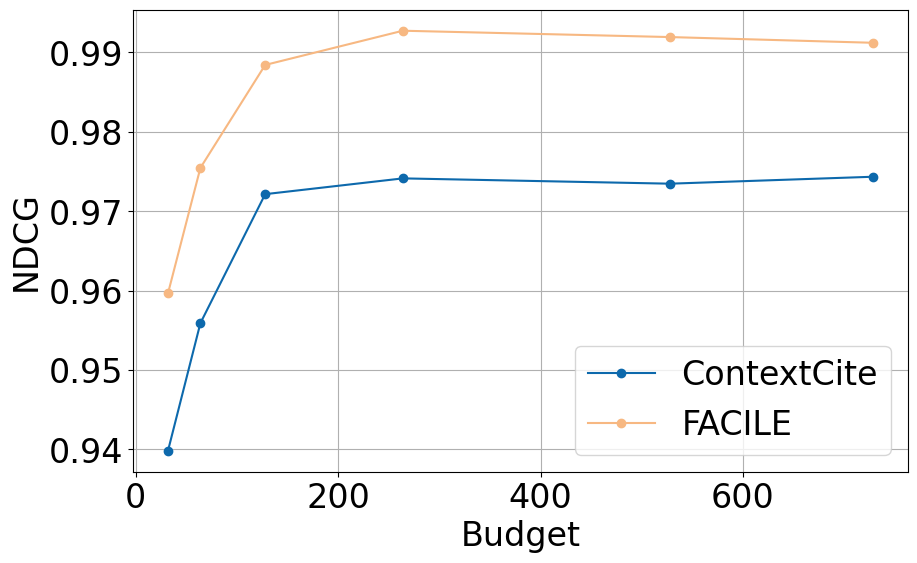

In [9]:
# Parse methods and budgets
parsed = {}
budgets = set()
for key, values in spearmans.items():
    avg_val = np.mean(values)
    
    match = re.match(r"(.+?)_(\d+)$", key)  # method_budget pattern
    if match:
        method, budget = match.groups()
        budget = int(budget)
        budgets.add(budget)
        parsed.setdefault(method, {})[budget] = avg_val
    else:
        # constant methods (no budget)
        parsed.setdefault(key, {})[None] = avg_val

budgets = sorted(budgets)

# Plot
plt.figure(figsize=(10,6))

for method, results in parsed.items():
    if None in results:  # constant method
        plt.hlines(results[None], xmin=min(budgets), xmax=max(budgets), 
                   linestyles='--', label=method)
    else:
        xs = sorted(results.keys())
        ys = [results[b] for b in xs]

        if "Facile" not in method:
            plt.plot(xs, ys, marker='o', label=method, color=get_color(method))
        else:
            plt.scatter(xs, ys, marker='x', label=method)
plt.xlabel("Budget")
plt.ylabel("NDCG")
plt.legend()
plt.grid(True)
# plt.savefig(f"../Figures/{model_path.split('/')[1].split('-')[0]}/ndcg_vs_budget_marginal.pdf", bbox_inches='tight')
plt.show()


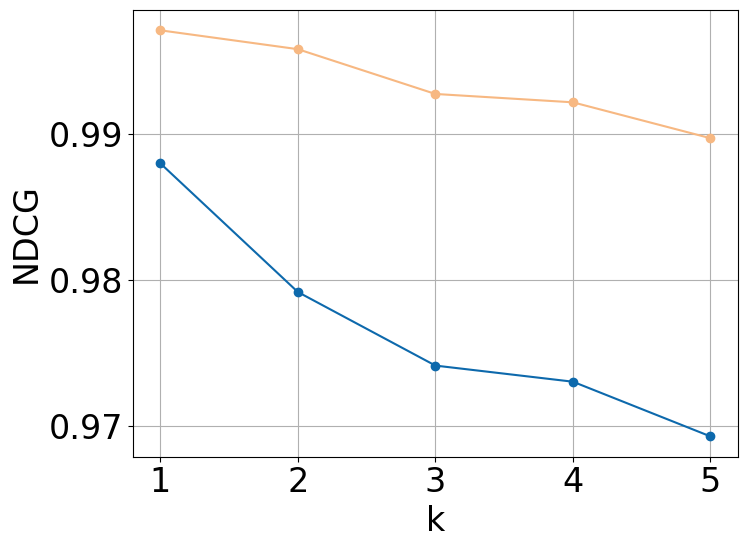

In [10]:
spearmans_per_k = {k: {i: [] for i in all_results[0]['methods'] if "Exact" not in i}
                   for k in K_VALUES}

# Compute NDCG@k for each k, for each method, across experiments
for method_res in all_results:
    for method, attribution in method_res['methods'].items():
        if "Exact" in method:
            continue
        
        # Convert to numpy arrays for scaling
        ref = np.array(method_res['methods']["Exact-Shap"]).reshape(-1, 1)
        att = np.array(attribution).reshape(-1, 1)

        # Scale both reference and attribution to [0, 1]
        ref_scaled = scaler.fit_transform(ref).flatten()
        att_scaled = scaler.fit_transform(att).flatten()

        # Compute NDCG@k for all K_VALUES
        for k in K_VALUES:
            spear = ndcg_score([ref_scaled], [att_scaled], k=k)
            spearmans_per_k[k][method].append(spear)

# Average over experiments: avg_spearmans_per_k[k][method] = mean NDCG@k
avg_spearmans_per_k = {
    k: {
        m: float(np.mean(vals)) for m, vals in methods_scores.items() if len(vals) > 0
    }
    for k, methods_scores in spearmans_per_k.items()
}

parsed_per_k = {}  # parsed_per_k[k][base_method][budget_or_None] = avg_val
all_budgets = set()

for k, method_dict in avg_spearmans_per_k.items():
    parsed_per_k[k] = {}
    for key, avg_val in method_dict.items():
        match = re.match(r"(.+?)_(\d+)$", key)  # method_budget pattern
        if match:
            method, budget = match.groups()
            budget = int(budget)
            all_budgets.add(budget)
            parsed_per_k[k].setdefault(method, {})[budget] = avg_val
        else:
            # constant methods (no budget)
            parsed_per_k[k].setdefault(key, {})[None] = avg_val

all_budgets = sorted(all_budgets)

# ---- Build data for fixed budget: metric vs k ----

# fixed_budget_results[method][k] = value at that budget
fixed_budget_results = {}
FIXED_BUDGET=264
for k in K_VALUES:
    for method, results in parsed_per_k[k].items():
        # budgeted methods
        if FIXED_BUDGET in results:
            fixed_budget_results.setdefault(method, {})[k] = results[FIXED_BUDGET]
        # constant methods (no budget) -> same value for all k, if you want them
        elif None in results:
            fixed_budget_results.setdefault(method, {})[k] = results[None]


plt.figure(figsize=(8,6))

for method, k_dict in fixed_budget_results.items():
    ks_sorted = sorted(k_dict.keys())
    ys = [k_dict[kk] for kk in ks_sorted]
    label = f"{method} (budget={FIXED_BUDGET})" if any(b.isdigit() for b in method) is False else method
    # You can simplify label if you want; here we keep "method" plus budget in the title
    plt.plot(ks_sorted, ys, marker='o', label=method, color=get_color(method))

plt.xlabel("k")
plt.ylabel("NDCG")
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def average_precision_for_query(scores, true_indices):
    true_set = set(true_indices)
    if len(true_set) == 0:
        return 0.0

    # Rank items by score (descending)
    ranked_indices = np.argsort(-scores)

    num_relevant = len(true_set)
    num_hits = 0
    precisions = []
    recalls = []

    for rank, idx in enumerate(ranked_indices, start=1):
        if idx in true_set:
            num_hits += 1
        precision = num_hits / rank
        recall = num_hits / num_relevant
        precisions.append(precision)
        recalls.append(recall)

    recalls = np.array(recalls)
    precisions = np.array(precisions)

    # Average Precision: area under PR via step approximation
    order = np.argsort(recalls)
    recalls = recalls[order]
    precisions = precisions[order]

    recalls_ext = np.concatenate(([0.0], recalls))
    precisions_ext = np.concatenate(([precisions[0]], precisions))

    ap = 0.0
    for i in range(1, len(recalls_ext)):
        delta_r = recalls_ext[i] - recalls_ext[i - 1]
        ap += delta_r * precisions_ext[i]

    return ap


def mean_pr_auc(all_scores):

    aps = []
    for i, scores in enumerate(all_scores):
        ap = average_precision_for_query(scores, GT(i))
        aps.append(ap)
    return float(np.mean(aps)) if aps else 0.0


In [12]:
def map_from_scores(all_scores, gtset_k):
    n = all_scores.shape[0]

    # Build binary relevance vector y_true
    y_true = np.zeros(n, dtype=int)
    y_true[list(gtset_k)] = 1

    # y_scores is just the scores
    y_scores = all_scores

    if y_true.sum() == 0:
        # no relevant docs; convention: skip or count AP=0
        ap = 0.0
    else:
        ap = average_precision_score(y_true, y_scores)

    return ap

In [13]:
aps={i:[] for i in all_results[0]["methods"].keys()}
for i, rw in enumerate(all_results):
    for method in aps:
        aps[method].append(map_from_scores(rw["methods"][method], GT(i)))
    

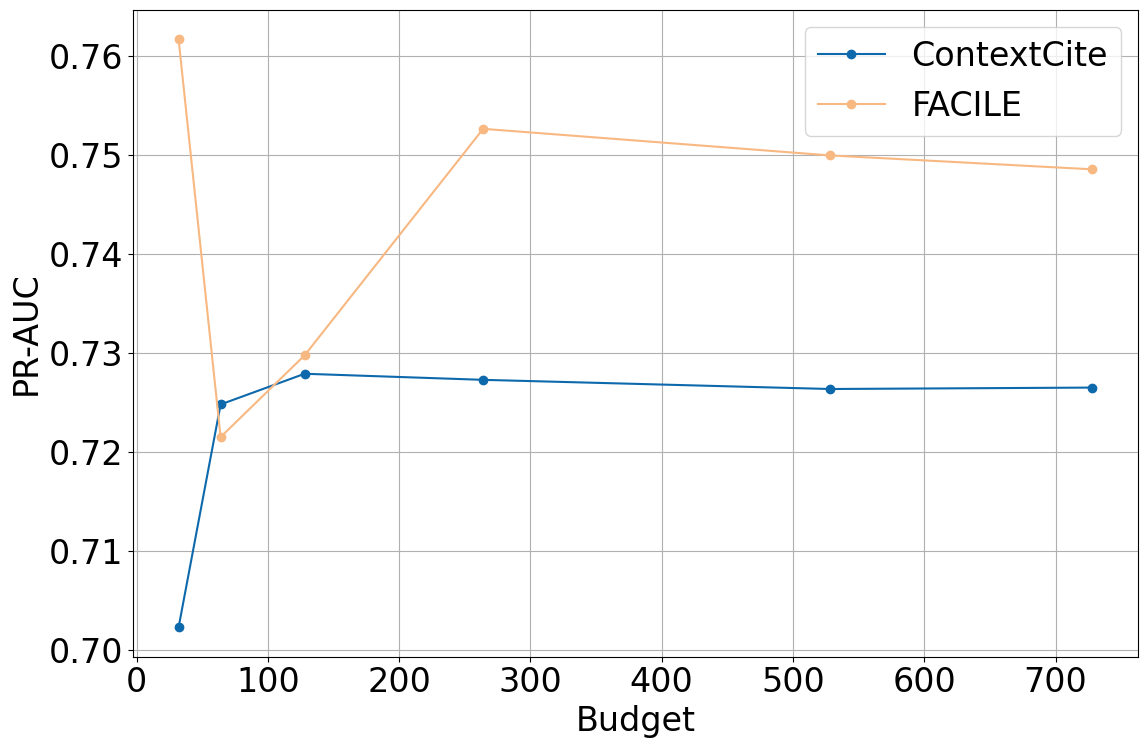

In [14]:
constant_methods =  ['Exact-Shap', 'Exact-FSII', 'Exact-Banzhaf', 'Exact-FBII']   # adjust if needed

# Containers
budgeted_data = {}   # family -> list of (budget, mean_value)
constant_data = {}   # method -> mean_value

for method, values in aps.items():
    mean_val = float(np.mean(values))

    if method in constant_methods:
        constant_data[method] = mean_val
    else:
        # split family and budget: e.g. "Shapiq_528" -> ("Shapiq", 528)
        parts = method.split("_")
        family = "_".join(parts[:-1])
        budget = int(parts[-1])

        if family not in budgeted_data:
            budgeted_data[family] = []
        budgeted_data[family].append((budget, mean_val))

# sort by budget
for family in budgeted_data:
    budgeted_data[family] = sorted(budgeted_data[family], key=lambda x: x[0])

plt.figure(figsize=(12,8))

# Plot budgeted families
for family, items in budgeted_data.items():
    budgets = [b for b, _ in items]
    means = [m for _, m in items]
    if "Facile" not in family:
        plt.plot(budgets, means, marker='o', label=family, color=get_color(family))
    else:   
        plt.scatter(budgets, means, marker='X', label=family)

# Plot constant methods as horizontal lines
# for method, mean_val in constant_data.items():
#     print(f"Plotting constant method {method} with mean PR-AUC {mean_val:.4f}")
#     plt.axhline(y=mean_val, linestyle='--', label=method)
    

plt.xlabel("Budget")
plt.ylabel("PR-AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../Figures/{model_path.split('/')[1].split('-')[0]}/prauc_vs_budget_marginal.pdf", bbox_inches='tight')
plt.show()


In [15]:
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]
        # LDS and R2
        for method_name, lds_val in metrics.get("LDS", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        for method_name, r2_val in metrics.get("R2", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(r2_val)

        # Delta R2 (new)
        for method_name, delta_val in metrics.get("Delta_R2", {}).items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["Delta_R2"].append(delta_val)

        # Top-k
        for method_name, k_dict in metrics.get("topk_probability", {}).items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])
        
        for method_name, k_dict in metrics.get("Recall", {}).items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                col_name = f"Recall@{k}"
                table_data[method][col_name].append(k_dict[k-1])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and Delta_R2
    for method, metric_dict in table_data.items():
        for metric in ["LDS", "R2", "Delta_R2"]:
            if metric in metric_dict:
                avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])



=== Metrics Summary Across All Queries ===
                   LDS      R2  Delta_R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5  Recall@1  Recall@2  Recall@3  Recall@4  Recall@5  LDS_std  R2_std  Delta_R2_std
ContextCite_128 0.7742 -0.0937    0.2981               3.6486               5.4765               6.1734               6.4498               6.5425    0.2997    0.5152    0.5951    0.6481    0.7079   0.1461  6.9786        0.2983
ContextCite_264 0.7747  0.2891    0.2951               3.6731               5.4817               6.1449               6.6108               6.7827    0.3047    0.5152    0.5901    0.6465    0.6886   0.1509  3.2338        0.3018
ContextCite_32  0.7487  0.5353    0.2116               3.5926               5.2820               5.5994               6.1317               6.2709    0.2820    0.4663    0.5497    0.6279    0.6801   0.1496  0.4658        0.6067
ContextCite_528 0.7789  0.4265    0.2991        

/tmp/ipykernel_666644/2796312287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_666644/2796312287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))


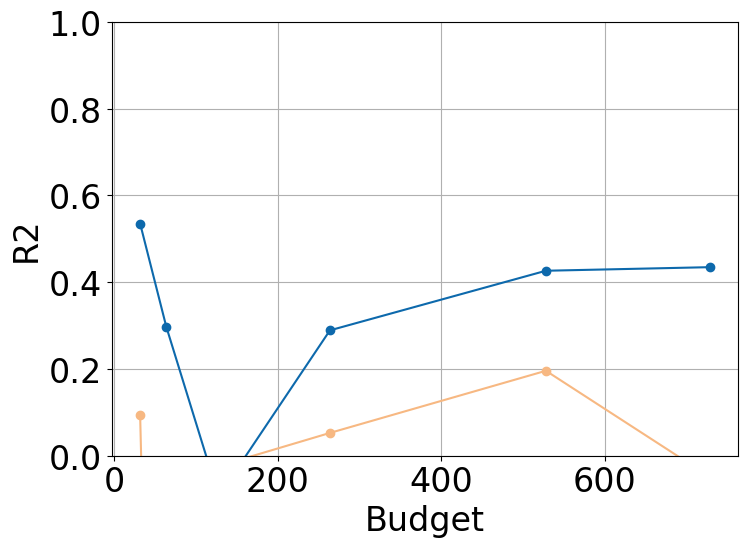

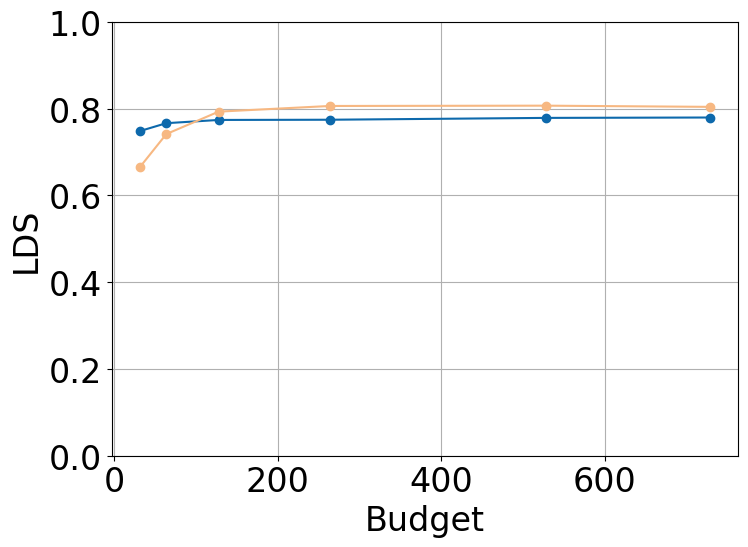

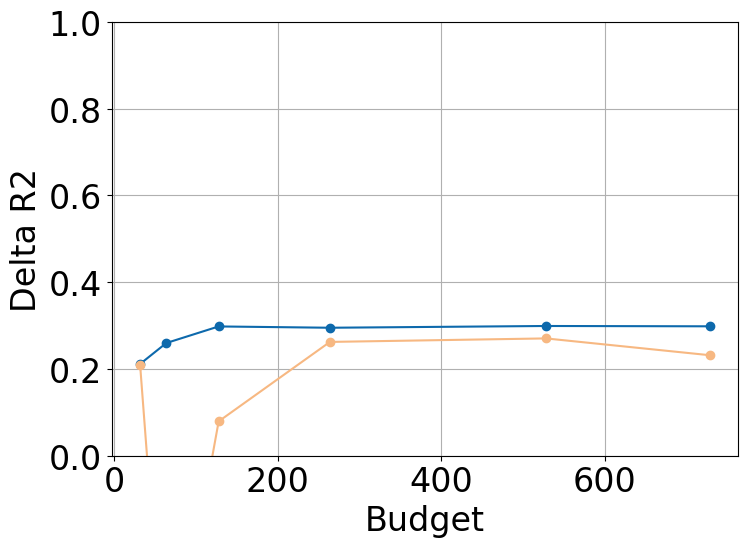

In [16]:
# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['Exact-Shap', 'Exact-FSII', 'Exact-Banzhaf', 'Exact-FBII']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(8, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        subset = df_budgeted[df_budgeted['family'] == fam]
        if "Facile" in fam:
            plt.scatter(subset['budget'], subset[metric], marker='x', label=fam)  # Dummy for legend
        else:
            plt.plot(subset['budget'], subset[metric], marker='o', label=fam, color=get_color(fam))

    # Plot constant methods as horizontal lines
    colors = plt.cm.tab10.colors  # categorical palette
    # for idx, (_, row) in enumerate(df_const.iterrows()):
    #     plt.axhline(y=row[metric], color=colors[idx % len(colors)],marker='x', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    # plt.title(f"Evolution of {ylabel} with Increasing Budget")
    # plt.legend()
    ax = plt.gca()
    ax.set_ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"../Figures/{model_path.split('/')[1].split('-')[0]}/{metric.lower()}_vs_budget_marginal.pdf", bbox_inches='tight')  
    plt.show()

plot_metric("R2", "R2")
plot_metric("LDS", "LDS")
plot_metric("Delta_R2", "Delta R2")

In [ ]:
# Filter budgeted methods at budget = 274
df_budgeted_264 = df_budgeted[df_budgeted['budget'] == 128]

# Metrics to plot
recall_metrics = [f"Recall@{k}" for k in range(1, 6)]
k_values = list(range(1, 6))

plt.figure(figsize=(8,6))

# Plot budgeted families at budget 274
families = df_budgeted_264['family'].unique()
for fam in families:
    # if 'LK' not in fam:
    subset = df_budgeted_264[df_budgeted_264['family'] == fam]
    if not subset.empty:
        recalls = subset[recall_metrics].values.flatten()
        if "Facile" in fam:
            plt.scatter(k_values, recalls, marker='x', linestyle="--", label=fam)
        else:
            plt.plot(k_values, recalls, marker='o', label=fam, color=get_color(fam))

# Plot constant methods
# for idx, (_, row) in enumerate(df_const.iterrows()):
#     recalls = [row[m] for m in recall_metrics]
#     plt.plot(k_values, recalls, marker='x', linestyle="--", label=row['method'])

plt.xlabel("k")
plt.ylabel("Recall@k")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../Figures/{DATA_CSV.stem}/{model_path.split('/')[1].split('-')[0]}/recall_at_k.pdf", bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
for method in df_res.index:
    if "264" in method :
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method.split("_")[0]
        )

plt.xlabel('k')
plt.ylabel('Top-k Removal Drop')
# plt.title('Top-k log-perplexityability Drop')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../Figures/{DATA_CSV.stem}/{model_path.split('/')[1].split('-')[0]}/topk_removal.pdf", bbox_inches='tight')
plt.show()

# 1. Recall@k wrt ground truth (positive and negative interactions)

In [ ]:
def recall_at_k(similarity_dict, ground_truth, k):
    """
    sorted_pairs_desc: [((i, j), value), ...] sorted by value desc
    ground_truth: list of [i, j] or (i, j), all with i < j
    k: int
    """
    sorted_pairs_desc = sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)
    gt_set = {tuple(pair) for pair in ground_truth}
    top_k_pairs = [pair for (pair, _) in sorted_pairs_desc[:k]]
    top_k_set = set(top_k_pairs)
    
    hits = sum(1 for gt in gt_set if gt in top_k_set)
    return hits / len(gt_set)


In [ ]:
from itertools import combinations
k=5
recall_at_k_average={i:[] for i in extras[1].keys()}
for en, A in enumerate(extras):
    pos_int_gt=[list(pair) for pair in combinations(GT(en), 2)]
    for name, inter_value in A.items():
        if "FM" in name:
            similarity_dict = {
            (i, j): inter_value[i][j]
            for i in range(len(inter_value))
            for j in range(i + 1, len(inter_value))
            }
            recall_at_k_average[name].append(recall_at_k(similarity_dict, pos_int_gt, k))
        else:
            recall_at_k_average[name].append(recall_at_k(inter_value, pos_int_gt, k))

In [ ]:
[{n:sum(l)/len(l)} for n, l in recall_at_k_average.items()]

In [ ]:
rr_avg

# 2. RR@k

In [ ]:
# Parse RR@k for all experiments and budgets
def compute_rr_at_k(interaction, ground_truth, k):
    """
    Compute Recovery@k for a method's interaction dict or matrix.
    interaction: dict {(i, j): value} or 2D numpy array/matrix
    ground_truth: set of ground-truth indices (R^*)
    k: number of top interactions to consider
    Returns: RR@k value
    """
    
    # Convert matrix to dict if needed
    if isinstance(interaction, (np.ndarray, list)):
        mat = np.array(interaction)
        pairs = {(i, j): mat[i][j] for i in range(mat.shape[0]) for j in range(mat.shape[1]) if i != j}
    else:
        pairs = interaction

    # Sort pairs by value (descending)
    sorted_pairs = sorted(pairs.items(), key=lambda x: x[1], reverse=True)
    rr_sum = 0.0
    for i in range(min(k, len(sorted_pairs))):
        pair_indices = set(sorted_pairs[i][0])
        rr_sum += len(ground_truth & pair_indices) / len(pair_indices)
    return rr_sum / k if k > 0 else 0.0

def extract_budget(key):
    match = re.search(r'_(\d+)$', key)
    return int(match.group(1)) if match else None

def extract_family(key):
    if key.startswith("FM-S"):
        return 'FM-S'
    elif key.startswith("FM_"):
        return key
    elif key.startswith("FM"):
        return "FM"
    elif key.startswith("FM-P"):
        return "FM-P"
    elif key.startswith("Spex-B"):
        return "Spex-B"
    elif key.startswith("Spex-S"):
        return "Spex-S"
    elif key.startswith("ProxySpex-S"):
        return "ProxySpex-S"
    elif key.startswith("ProxySpex-B"):
        return "ProxySpex-B"
    elif key.startswith("Shapiq-S"):
        return "Shapiq-S"
    elif key.startswith("Shapiq-B"):
        return "Shapiq-B"
    elif key.startswith("ContextCite"):
        return "ContextCite"
    elif key.startswith("Facile"):
        return "Facile"
    elif key.startswith("Facile_2"):
        return "Facile_2"
    elif key.startswith("Facile_8"):
        return "Facile_8"
    elif key.startswith("Facile_4"):
        return "Facile_4"
    return None

def collect_rr_at_k_over_budgets(extras, k):
    # For each experiment, for each method, collect RR@k by budget
    rr_by_method_budget = defaultdict(lambda: defaultdict(list))
    for i, exp in enumerate(extras):
        for method, interaction in exp.items():
            budget = extract_budget(method)
            family = extract_family(method)
            if budget and family:
                rr = compute_rr_at_k(interaction, set(GT(i)), k)
                rr_by_method_budget[family][budget].append(rr)
    # Average over experiments
    rr_avg = defaultdict(dict)
    for family, budgets in rr_by_method_budget.items():
        for budget, vals in budgets.items():
            rr_avg[family][budget] = np.mean(vals)
    return rr_avg
rr_avg = collect_rr_at_k_over_budgets(extras, 3)
# Plot RR@k as line chart for each method family, with constant methods as parallel lines
plt.figure(figsize=(8,6))

# Plot budgeted families
for family, budget_rrs in rr_avg.items():
    budgets = sorted(budget_rrs.keys())
    values = [budget_rrs[b] for b in budgets]
    if "FN" in family:
        plt.scatter(budgets, values, marker='x', label=family, color=get_color(family))
    else:
        plt.plot(budgets, values, marker='o', label=family, color=get_color(family))

# Plot constant methods (e.g., Exact-FSII, LOO, ARC-JSD) as horizontal lines
constant_methods = ['Exact-FSII', 'Exact-FBII', 'ARC-JSD']
for method in constant_methods:
    # Collect RR@k for each experiment and average
    rr_vals = []
    for exp in extras:
        if method in exp:
            rr_vals.append(compute_rr_at_k(exp[method], set(GT(i)), k))
    if rr_vals:
        avg_rr = np.mean(rr_vals)
        plt.axhline(y=avg_rr, color=get_color(method), linestyle='--', label=method)

plt.xlabel('Budget')
plt.ylabel(f'RR@k')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../Figures/{model_path.split('/')[1].split('-')[0]}/rr@5_rank.pdf", bbox_inches='tight')

plt.show()


In [ ]:
rr_by_family_budget_k = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
FIXED_BUDGET=724
for i, exp in enumerate(extras):
    gt = set(GT(i))  # assuming GT(i) is defined as in your original code
    for method, interaction in exp.items():
        budget = extract_budget(method)
        family = extract_family(method)
        if budget is not None and family is not None:
            for k in K_VALUES:
                rr = compute_rr_at_k(interaction, gt, k)
                rr_by_family_budget_k[family][budget][k].append(rr)

# Average over experiments: rr_avg[family][budget][k] = mean RR@k
rr_avg = defaultdict(lambda: defaultdict(dict))
for family, budgets in rr_by_family_budget_k.items():
    for budget, k_vals in budgets.items():
        for k, vals in k_vals.items():
            if vals:
                rr_avg[family][budget][k] = float(np.mean(vals))

# For plotting: at FIXED_BUDGET, collect RR@k for each family
family_rr_at_k = defaultdict(dict)   # family_rr_at_k[family][k] = RR@k

for family, budgets in rr_avg.items():
    if FIXED_BUDGET in budgets:
        for k in K_VALUES:
            if k in budgets[FIXED_BUDGET]:
                family_rr_at_k[family][k] = budgets[FIXED_BUDGET][k]

# ---------- Plot: RR@k vs k at fixed budget ----------

plt.figure(figsize=(8,6))

for family, k_dict in family_rr_at_k.items():
    ks_sorted = sorted(k_dict.keys())
    values = [k_dict[kk] for kk in ks_sorted]
    if "FR" in family:
        plt.scatter(ks_sorted, values, marker='x', label=f'{family} (budget={FIXED_BUDGET})', color=get_color(family))
    else:
        plt.plot(ks_sorted, values, marker='o', label=f'{family} (budget={FIXED_BUDGET})', color=get_color(family))

plt.xlabel('k (RR@k)')
plt.ylabel('RR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
family_rr_at_k

# 3. NDCG to Exact-FSII

In [ ]:
def extract_budget(key):
    m = key.split('_')[-1]
    return int(m) if m.isdigit() else None

def extract_family(key):
    if key.startswith("FM-S"):
        return 'FM-S'
    elif key.startswith("FM-B"):
        return "FM-B"
    elif key.startswith("FN-S"):
        return "FN-S"
    elif key.startswith("Spex-B"):
        return "Spex-B"
    elif key.startswith("Spex-S"):
        return "Spex-S"
    elif key.startswith("ProxySpex-S"):
        return "ProxySpex-S"
    elif key.startswith("ProxySpex-B"):
        return "ProxySpex-B"
    elif key.startswith("Shapiq-S"):
        return "Shapiq-S"
    elif key.startswith("Shapiq-B"):
        return "Shapiq-B"
    elif key.startswith("ContextCite"):
        return "ContextCite"
    elif key.startswith("Facile"):
        return "Facile"
    elif key.startswith("FN_2"):
        return "FN_2"
    elif key.startswith("FN_8"):
        return "FN_8"
    elif key.startswith("FN_4"):
        return "FN_4"
    return None
def pairs_from_exact(exp_list):
    # Find a canonical pair ordering from Exact-FSII of the first experiment that has it
    for exp in exp_list:
        exact = exp.get('Exact-FSII')
        if exact and isinstance(exact, dict):
            return sorted(exact.keys())
    # fallback: try to infer from any dict-valued method
    for exp in exp_list:
        for v in exp.values():
            if isinstance(v, dict) and v:
                return sorted(v.keys())
    return []

def vector_for_pairs(val, pairs):
    # val can be dict {(i,j):score} or a square matrix/list/ndarray
    if isinstance(val, (list, np.ndarray)):
        mat = np.array(val)
        return [abs(mat[i][j]) if (0 <= i < mat.shape[0] and 0 <= j < mat.shape[1]) else 0.0 for (i,j) in pairs]
    elif isinstance(val, dict):
        return [abs(val.get(pair, 0.0)) for pair in pairs]
    else:
        # Unknown type -> zeros
        return [0.0 for _ in pairs]

# Build canonical pair list
pairs = pairs_from_exact(extras)
if not pairs:
    print('No pair ordering could be inferred from Exact-FSII or other dicts in extras. Aborting NDCG computation.')
else:
    # Compute per-experiment NDCG scores for each method (relative to Exact-FSII)
    per_method_ndcg = defaultdict(list)
    for exp in extras:
        exact = exp.get('Exact-FSII', {})
        exact_vec = vector_for_pairs(exact, pairs)
        # if exact vector is all zeros, skip this experiment for fairness
        if np.allclose(exact_vec, 0.0):
            continue
        for method, val in exp.items():
            if method == 'Exact-FBII':
                continue
            try:
                vec = vector_for_pairs(val, pairs)
                # ndcg_score expects shape (n_samples, n_labels) for both y_true and y_score
                score = ndcg_score([exact_vec], [vec], k=3)
                per_method_ndcg[method].append(score)
            except Exception:
                # skip methods we cannot convert
                continue

    # Average NDCG across experiments for each method
    avg_ndcg = {m: float(np.mean(scores)) for m, scores in per_method_ndcg.items() if len(scores)>0}

    # Group budgeted methods by family and budget
    family_budget = defaultdict(lambda: defaultdict(list))
    for method, score in avg_ndcg.items():
        budget = extract_budget(method)
        family = extract_family(method)
        if budget is not None and family is not None:
            family_budget[family][budget].append(score)

    # Compute mean per family-budget (in case multiple variant keys map to same family-budget)
    family_budget_avg = {}
    for fam, bd in family_budget.items():
        family_budget_avg[fam] = {b: float(np.mean(vals)) for b, vals in bd.items()}

    # Plotting: line per family (budgeted), horizontal lines for constant methods
    plt.figure(figsize=(8,6))
    # Plot budgeted families
    for fam, bd in family_budget_avg.items():
        xs = sorted(bd.keys())
        ys = [bd[x] for x in xs]
        if "FR" in fam:
            plt.scatter(xs, ys, marker='x', label=fam, color=get_color(fam))
        else:
            plt.plot(xs, ys, marker='o', label=fam, color=get_color(fam))

    # Constant methods: plot as horizontal lines using avg_ndcg if available
    constant_methods = ['Exact-FSII','Exact-Shap','LOO','ARC-JSD']
    for cm in constant_methods:
        if cm in avg_ndcg:
            plt.axhline(y=avg_ndcg[cm], linestyle='--', label=cm)

    plt.xlabel('Budget')
    plt.ylabel('NDCG')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"../Figures/{model_path.split('/')[1].split('-')[0]}/ndcg@5_interactions.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
family_budget_avg

In [ ]:
# Build canonical pair list
pairs = pairs_from_exact(extras)
if not pairs:
    print('No pair ordering could be inferred from Exact-FSII or other dicts in extras. Aborting NDCG computation.')
else:
    # per_method_ndcg[k][method] = [scores across experiments]
    per_method_ndcg = {k: defaultdict(list) for k in K_VALUES}

    for exp in extras:
        exact = exp.get('Exact-FBII', {})
        exact_vec = vector_for_pairs(exact, pairs)
        if np.allclose(exact_vec, 0.0):
            continue

        for method, val in exp.items():
            if method == 'Exact-FBII':
                continue
            try:
                vec = vector_for_pairs(val, pairs)
                for k in K_VALUES:
                    score = ndcg_score([exact_vec], [vec], k=k)
                    per_method_ndcg[k][method].append(score)
            except Exception:
                continue

    # Average NDCG across experiments for each k and each method
    avg_ndcg_per_k = {
        k: {m: float(np.mean(scores)) for m, scores in md.items() if len(scores) > 0}
        for k, md in per_method_ndcg.items()
    }

    # For budgeted methods: group by family at the FIXED_BUDGET
    # family_ndcg_at_k[family][k] = mean NDCG for that family at that k and budget
    family_ndcg_at_k = defaultdict(dict)

    for k, avg_ndcg in avg_ndcg_per_k.items():
        # group budgeted methods by family at the chosen budget
        family_scores = defaultdict(list)
        for method, score in avg_ndcg.items():
            budget = extract_budget(method)
            family = extract_family(method)
            if budget == FIXED_BUDGET and family is not None:
                family_scores[family].append(score)

        # average over possible variants within family
        for fam, scores in family_scores.items():
            if scores:
                family_ndcg_at_k[fam][k] = float(np.mean(scores))

    # Constant methods (no budget) as a function of k
    constant_methods = ['Exact-FSII', 'Exact-Shap', 'LOO', 'ARC-JSD']
    constant_ndcg_per_k = {cm: {} for cm in constant_methods}
    for k, avg_ndcg in avg_ndcg_per_k.items():
        for cm in constant_methods:
            if cm in avg_ndcg:
                constant_ndcg_per_k[cm][k] = avg_ndcg[cm]

    # ---- Plot: NDCG vs k at fixed budget ----
    plt.figure(figsize=(8, 6))

    # Plot budgeted families at the fixed budget
    for fam, kd in family_ndcg_at_k.items():
        ks_sorted = sorted(kd.keys())
        ys = [kd[kk] for kk in ks_sorted]
        plt.plot(ks_sorted, ys, marker='o', label=f'{fam} (budget={FIXED_BUDGET})', color=get_color(fam))

    # Plot constant methods as lines over k
    # for cm, kd in constant_ndcg_per_k.items():
    #     if kd:
    #         ks_sorted = sorted(kd.keys())
    #         ys = [kd[kk] for kk in ks_sorted]
    #         plt.plot(ks_sorted, ys, linestyle='--', marker='x', label=cm)

    plt.xlabel('k')
    plt.ylabel('NDCG')
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
family_ndcg_at_k

In [ ]:
import matplotlib.lines as mlines
legend_methods = [
    "FM-Shapley", "Spex", "Shapiq", "ContextCite"
]

# Create Line2D handles with fixed color and linestyle
handles = [
    mlines.Line2D(
        [], [],
        color=get_color(m),  # use your METHOD_COLORS mapping
        linestyle='-',       # solid line for all
        marker='o',          # optional marker
        label=m
    )
    for m in legend_methods
]

# Standalone legend figure
fig_leg, ax_leg = plt.subplots(figsize=(8, 2.5))
ax_leg.axis('off')  # hide axes

ax_leg.legend(
    handles=handles,
    loc='center',
    ncol=5,        # number of columns in legend
    frameon=False, # no box
    handlelength=2.5,
    columnspacing=1.2
)

plt.tight_layout()
fig_leg.savefig("legend_4.pdf", bbox_inches='tight')
plt.show()